In [1]:
# Create config file
with open('config.py', 'w') as fp:
    fp.write(
'''import os
base_path = os.path.abspath(".")
data_path = os.path.abspath("simulations")
jobscript_template = "python {base_path}/run_simulation.py {label}"
submit_cmd = "bash -c"
''')

In [2]:
import numpy as np
import sys
import os

from multiarea_model import MultiAreaModel
from multiarea_model import Analysis
from config import base_path, data_path

sys.path.append('./figures/MAM2EBRAINS')
from M2E_compute_rate_time_series import compute_rate_time_series
from compute_save_fc import compute_fc


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Oct 15 2023 15:12:16

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [3]:
# def perform_simulation(param):
#     scale_down_to = 0.006
    
#     cc_weights_factor = param

#     complete_area_list = ['V1', 'V2', 'VP', 'V3', 'V3A', 'MT', 'V4t', 'V4', 'VOT', 'MSTd',
#                           'PIP', 'PO', 'DP', 'MIP', 'MDP', 'VIP', 'LIP', 'PITv', 'PITd',
#                           'MSTl', 'CITv', 'CITd', 'FEF', 'TF', 'AITv', 'FST', '7a', 'STPp',
#                           'STPa', '46', 'AITd', 'TH']

#     areas_simulated = complete_area_list

#     replace_non_simulated_areas = 'het_poisson_stat'

#     g = -11.

#     rate_ext = 10.
    
#     # Determine replace_cc_input_source
#     replace_cc_input_source = None                                               # By default, replace_cc_input_source is set to None
#                                                                                  # where areas_simulated is complete_area_list                                                           
#     if set(areas_simulated) != set(complete_area_list):                                                                                       
#         if replace_non_simulated_areas == 'hom_poisson_stat':                   
#             replace_cc_input_source = None
#         elif replace_non_simulated_areas == 'het_poisson_stat' or replace_non_simulated_areas == 'het_current_nonstat':
#             replace_cc_input_source = os.path.join(base_path, 'tests/fullscale_rates.json')
#         else:
#             raise Exception("'hom_poisson_stat', 'het_poisson_stat', or 'het_current_nonstat' should be assigned to replace_non_simulated_areas when not all areas are simulated!")

#     # Determine cc_weights_I_factor from cc_weights_factor
#     if cc_weights_factor == 1.0:                                                  # For ground state with cc_weights_factor as 1., 
#         cc_weights_I_factor = 1.0                                                 # cc_weights_I_factor is set to 1.
#     elif cc_weights_factor > 1.0:                                                 # For cc_weights_factor larger than 1.0,
#         cc_weights_I_factor = 2.0                                                 # cc_weights_I_factor is set to 2.
#     else:                                                                         # cc_weights_factor outside of (1., 2.5], raise error
#         raise Exception("A value that is equal to or larger than 1.0 should be assigned to the parameter cc_weights_factor!")

#     # Connection parameters
#     conn_params = {
#         'replace_non_simulated_areas': replace_non_simulated_areas,               # Whether to replace non-simulated areas by Poisson sources 
#         'g': g,                                                                   # It sets the relative inhibitory synaptic strength, by default: -11.
#         'replace_cc_input_source': replace_cc_input_source,                       # Specify the data used to replace non-simulated areas      
#         'cc_weights_factor': cc_weights_factor,
#         'cc_weights_I_factor': cc_weights_I_factor
#     }

#     # Input parameters
#     input_params = {
#         'rate_ext': rate_ext                                                      # Rate of the Poissonian spike generator (in spikes/s), by default: 10.
#     } 

#     # Network parameters
#     network_params = {
#         'N_scaling': scale_down_to,                                               # Scaling of population sizes, by default: 1. for full scale multi-area model
#         'K_scaling': scale_down_to,                                               # Scaling of indegrees, by default: 1. for full scale multi-area model
#         'fullscale_rates': os.path.join(base_path, 'tests/fullscale_rates.json'), # Absolute path to the file holding full-scale rates for scaling synaptic weights, by default: None
#         'input_params': input_params,                                             # Input parameters
#         'connection_params': conn_params,                                         # Connection parameters
#     } 

#     # Simulation parameters
#     sim_params = {
#         'areas_simulated': areas_simulated,                                       # Cortical areas included in the simulation
#         't_sim': 2000.,                                                           # Simulated time (in ms), by default: 10.
#         'rng_seed': 1                                                             # Global random seed
#     }
    
#     M = MultiAreaModel(network_params, 
#                    simulation=True,
#                    sim_spec=sim_params,
#                    theory=True)
    
#     # Run the simulation, depending on the model parameter and downscale ratio, the running time varies largely.
#     M.simulation.simulate()
    
#     label = M.simulation.label
#     A = Analysis(M, M.simulation, data_list=['spikes'], load_areas=None)
    
#     for area in M.area_list:
#             compute_rate_time_series(M, data_path, label, area, 'full')
            
#     param = cc_weights_factor
    
#     compute_fc(M, data_path, label, param)

In [4]:
# cc_weights_factor_list = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 3.0, 3.5, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

# for param in cc_weights_factor_list:
#     perform_simulation(param)

In [27]:
scale_down_to = 0.006

cc_weights_factor = 1.9

complete_area_list = ['V1', 'V2', 'VP', 'V3', 'V3A', 'MT', 'V4t', 'V4', 'VOT', 'MSTd',
                      'PIP', 'PO', 'DP', 'MIP', 'MDP', 'VIP', 'LIP', 'PITv', 'PITd',
                      'MSTl', 'CITv', 'CITd', 'FEF', 'TF', 'AITv', 'FST', '7a', 'STPp',
                      'STPa', '46', 'AITd', 'TH']

areas_simulated = complete_area_list

replace_non_simulated_areas = 'het_poisson_stat'

g = -11.

rate_ext = 10.

# Determine replace_cc_input_source
replace_cc_input_source = None                                               # By default, replace_cc_input_source is set to None
                                                                             # where areas_simulated is complete_area_list                                                           
if set(areas_simulated) != set(complete_area_list):                                                                                       
    if replace_non_simulated_areas == 'hom_poisson_stat':                   
        replace_cc_input_source = None
    elif replace_non_simulated_areas == 'het_poisson_stat' or replace_non_simulated_areas == 'het_current_nonstat':
        replace_cc_input_source = os.path.join(base_path, 'tests/fullscale_rates.json')
    else:
        raise Exception("'hom_poisson_stat', 'het_poisson_stat', or 'het_current_nonstat' should be assigned to replace_non_simulated_areas when not all areas are simulated!")

# Determine cc_weights_I_factor from cc_weights_factor
if cc_weights_factor == 1.0:                                                  # For ground state with cc_weights_factor as 1., 
    cc_weights_I_factor = 1.0                                                 # cc_weights_I_factor is set to 1.
elif cc_weights_factor > 1.0:                                                 # For cc_weights_factor larger than 1.0,
    cc_weights_I_factor = 2.0                                                 # cc_weights_I_factor is set to 2.
else:                                                                         # cc_weights_factor outside of (1., 2.5], raise error
    raise Exception("A value that is equal to or larger than 1.0 should be assigned to the parameter cc_weights_factor!")

# Connection parameters
conn_params = {
    'replace_non_simulated_areas': replace_non_simulated_areas,               # Whether to replace non-simulated areas by Poisson sources 
    'g': g,                                                                   # It sets the relative inhibitory synaptic strength, by default: -11.
    'replace_cc_input_source': replace_cc_input_source,                       # Specify the data used to replace non-simulated areas      
    'cc_weights_factor': cc_weights_factor,
    'cc_weights_I_factor': cc_weights_I_factor
}

# Input parameters
input_params = {
    'rate_ext': rate_ext                                                      # Rate of the Poissonian spike generator (in spikes/s), by default: 10.
} 

# Network parameters
network_params = {
    'N_scaling': scale_down_to,                                               # Scaling of population sizes, by default: 1. for full scale multi-area model
    'K_scaling': scale_down_to,                                               # Scaling of indegrees, by default: 1. for full scale multi-area model
    'fullscale_rates': os.path.join(base_path, 'tests/fullscale_rates.json'), # Absolute path to the file holding full-scale rates for scaling synaptic weights, by default: None
    'input_params': input_params,                                             # Input parameters
    'connection_params': conn_params,                                         # Connection parameters
} 

# Simulation parameters
sim_params = {
    'areas_simulated': areas_simulated,                                       # Cortical areas included in the simulation
    't_sim': 2000.,                                                           # Simulated time (in ms), by default: 10.
    'rng_seed': 1                                                             # Global random seed
}

M = MultiAreaModel(network_params, 
               simulation=True,
               sim_spec=sim_params,
               theory=True)

Initializing network from dictionary.
RAND_DATA_LABEL 3950


/srv/main-spack-instance-2309/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-10.3.0/py-numpy-1.23.5-rm3niouf5xjbvqy74ubkcuewixomy5ds/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning:Mean of empty slice.
/srv/main-spack-instance-2309/spack/opt/spack/linux-ubuntu20.04-x86_64/gcc-10.3.0/py-numpy-1.23.5-rm3niouf5xjbvqy74ubkcuewixomy5ds/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning:invalid value encountered in double_scalars




Customized parameters
--------------------
{'K_scaling': 0.006,
 'N_scaling': 0.006,
 'connection_params': {'cc_weights_I_factor': 2.0,
                       'cc_weights_factor': 1.9,
                       'g': -11.0,
                       'replace_cc_input_source': None,
                       'replace_non_simulated_areas': 'het_poisson_stat'},
 'fullscale_rates': '/opt/app-root/src/multi-area-model/tests/fullscale_rates.json',
 'input_params': {'rate_ext': 10.0}}


/srv/main-spack-instance-2309/spack/var/spack/environments/ebrains-23-09/.spack-env/view/lib/python3.8/site-packages/dicthash/dicthash.py:47: UserWarning:Float too small for safe conversion tointeger. Rounding down to zero.


Simulation label: d7d699dad9f64bfb7893ef60997cb2c4
Copied files.
Initialized simulation class.


In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import csv
import math

In [63]:
# Load experimental functional connectivity
func_conn_data = {}
with open('./figures/Schmidt2018_dyn/Fig8_exp_func_conn.csv', 'r') as f:
    myreader = csv.reader(f, delimiter='\t')
    # Skip first 3 lines
    next(myreader)
    next(myreader)
    next(myreader)
    areas = next(myreader)
    for line in myreader:
        dict_ = {}
        for i in range(len(line)):
            dict_[areas[i]] = float(line[i])
        func_conn_data[areas[myreader.line_num - 5]] = dict_

# Experimental functional connectivity
exp_FC = np.zeros((len(M.area_list),
                   len(M.area_list)))
for i, area1 in enumerate(M.area_list):
    for j, area2 in enumerate(M.area_list):
        exp_FC[i][j] = func_conn_data[area1][area2]

In [64]:
# cc_weights_factor_list = [
#     1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0,
#     2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3.0, 
#     3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9, 4.0, 
#     4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 
#     5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.0, 
#     6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8, 6.9, 7.0, 
#     7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8, 7.9, 8.0, 
#     8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9.0, 
#     9.1, 9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9, 10.0, 
#     10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9, 11.0, 
#     11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12.0, 
#     12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13.0, 
#     13.1, 13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9, 14.0, 
#     14.1, 14.2, 14.3, 14.4, 14.5, 14.6, 14.7, 14.8, 14.9, 15.0, 
#     15.1, 15.2, 15.3, 15.4, 15.5, 15.6, 15.7, 15.8, 15.9, 16.0, 
#     16.1, 16.2, 16.3, 16.4, 16.5, 16.6, 16.7, 16.8, 16.9, 17.0, 
#     17.1, 17.2, 17.3, 17.4, 17.5, 17.6, 17.7, 17.8, 17.9, 18.0, 
#     18.1, 18.2, 18.3, 18.4, 18.5, 18.6, 18.7, 18.8, 18.9, 19.0, 
#     19.1, 19.2, 19.3, 19.4, 19.5, 19.6, 19.7, 19.8, 19.9, 20.0,
#     21, 22, 23, 24, 25, 26, 27, 28, 29, 30
#     31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 
#     41, 42, 43, 44, 45, 46, 47, 47, 49, 50]
cc_weights_factor_list = [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 3.0, 3.5, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

In [65]:
# Load a list of simulated functional connectivity
sim_FC = {}
for param in cc_weights_factor_list:
    fn = os.path.join(data_path,
                      'parameter_scan',
                      'functional_connectivity_synaptic_input_{}.npy'.format(param))
    sim_FC[param] = np.load(fn)

In [66]:
def zero_diagonal(matrix):
    """
    Return copy of a matrix with diagonal set to zero.
    """
    M = copy.copy(matrix)
    for i in range(M.shape[0]):
        M[i, i] = 0
    return M

In [67]:
# Compute correlation coefficient
cc_list = []
rsme_list = []
for i, param in enumerate(cc_weights_factor_list):
    # Pearson correlation
    cc = np.corrcoef(zero_diagonal(sim_FC[param]).flatten(),
                     zero_diagonal(exp_FC).flatten())[0][1]
    cc_list.append(cc)
    # RSME
    rsme = np.sqrt(np.mean((sim_FC[param]-exp_FC)**2))
    rsme_list.append(rsme)

# RSME similarity
rsme_sim_list = np.exp(-(rsme_list/np.std(zero_diagonal(exp_FC).flatten())))

# Initialize the list to store tuples of (absolute difference, value, index)
differences = [(abs(0.4 - value), value, cc_weights_factor_list[index]) for index, value in enumerate(cc_list)]

# Sort the list based on the absolute difference
differences.sort()
# print(differences)
print(differences[0])

(0.0015847317063646948, 0.4015847317063647, 7.0)


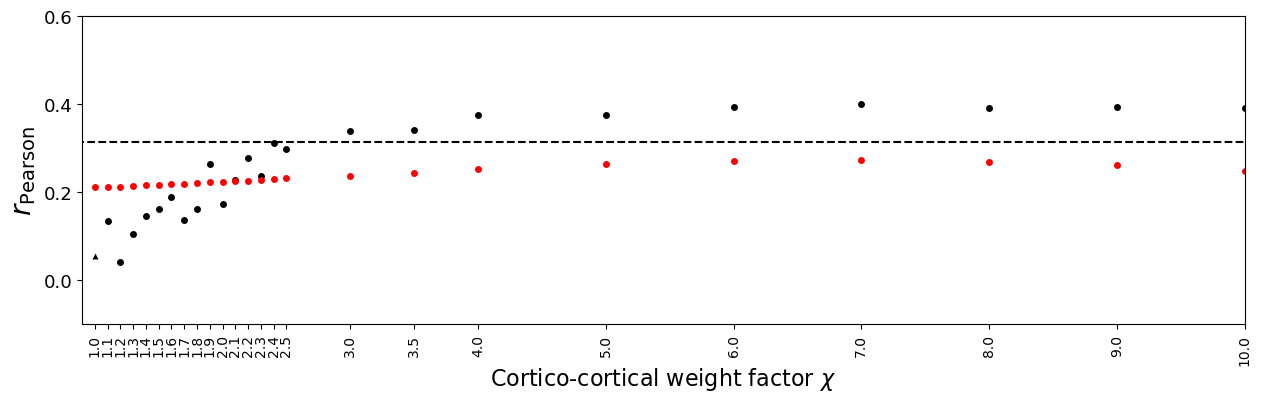

In [68]:
# Plotting
fig = plt.figure(figsize=(15, 4))
ax = plt.subplot()

# Plot the correlation coefficient
ax.plot(cc_weights_factor_list[1:], cc_list[1:], '.', ms=10,
        markeredgecolor='none', label='Sim. vs. Exp.', color='k')
ax.plot(cc_weights_factor_list[0], cc_list[0], '^', ms=5,
        markeredgecolor='none', label='Sim. vs. Exp.', color='k')

# Plot the RSME similarity
ax.plot(cc_weights_factor_list, rsme_sim_list, '.', ms=10,
        markeredgecolor='none', label='Sim. vs. Exp.', color='r')

# Correlation between exp. FC and structural connectivity
# Construct the structural connectivity as the matrix of relative
conn_matrix = np.zeros((len(M.area_list), len(M.area_list)))
for i, area1 in enumerate(M.area_list):
    s = np.sum(list(M.K_areas[area1].values()))
    for j, area2 in enumerate(M.area_list):
        value = M.K_areas[area1][area2] / s
        conn_matrix[i][j] = value

# Compute correlation between exp. FC and structural connectivity
cc = np.corrcoef(zero_diagonal(conn_matrix).flatten(),
                 zero_diagonal(exp_FC).flatten())[0][1]

# Formatting
ax.hlines(cc, -0.1, 15, linestyle='dashed', color='k')
ax.set_xlabel(r'Cortico-cortical weight factor $\chi$',
              labelpad=-0.1, size=16)
ax.set_ylabel(r'$r_{\mathrm{Pearson}}$', size=20)
ax.set_xlim((0.9, 10.0))
ax.set_ylim((-0.1, 0.6))
ax.set_yticks([0., 0.2, 0.4, 0.6])
ax.set_yticklabels([0., 0.2, 0.4, 0.6], size=13)
ax.set_xticks(cc_weights_factor_list)
ax.set_xticklabels(cc_weights_factor_list, size=10, rotation=90)

plt.show()

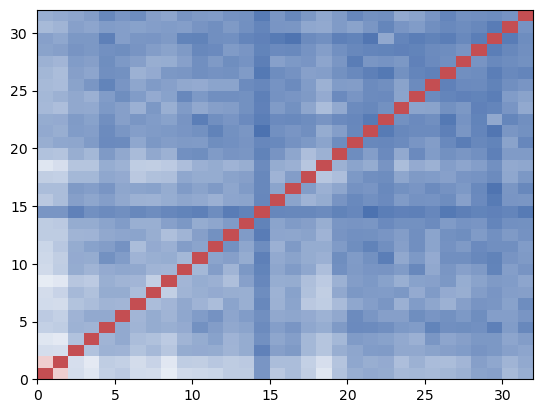

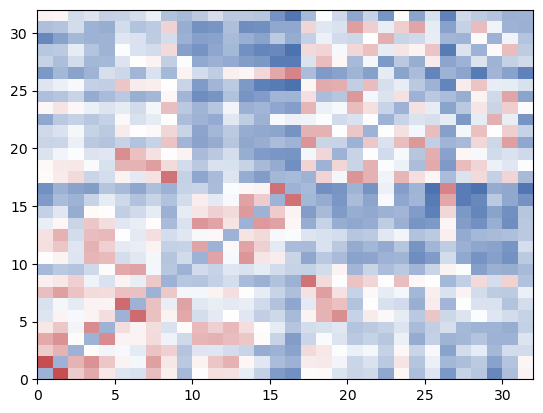

In [73]:
# Plotting
sys.path.append('./figures/Schmidt2018_dyn')
from plotcolors import myred, myblue
cmap = pl.cm.coolwarm
cmap = cmap.from_list('mycmap', [myblue, 'white', myred], N=256)

ax1 = plt.subplot()

ax1.pcolormesh(sim_FC[7.0], cmap=cmap)
plt.show()

ax2 = plt.subplot()
ax2.pcolormesh(exp_FC, cmap=cmap)

plt.show()